# 📊 Project: The Intelligent FP&A Command Center
### *Automating Price-Volume-Mix (PVM) Analysis & Forecasting using Python & Power BI*

---

## 1. 💼 Business Understanding
**The Challenge:**
Traditional FP&A processes rely heavily on static Excel models for variance analysis. This limits the ability to handle large datasets (SKU-level granularity) and perform sophisticated "What-If" scenarios. Strategic finance requires moving from "What happened?" (Reporting) to "Why it happened?" (Analytics) and "What will happen?" (Forecasting).

**The Objective:**
To build an automated, scalable end-to-end analytical pipeline that:
1.  **Ingests** financial transaction data.
2.  **Calculates** complex Price-Volume-Mix (PVM) variances programmatically.
3.  **Predicts** future revenue trends using Machine Learning (Prophet/ARIMA).
4.  **Visualizes** insights in an interactive Power BI dashboard for executive decision-making.

---

## 2. 🔄 Methodology: CRISP-DM
This project follows the **Cross-Industry Standard Process for Data Mining (CRISP-DM)** framework:

* **Phase 1: Business Understanding:** Defining the PVM and Forecasting logic (Completed).
* **Phase 2: Data Understanding:** Generating synthetic sales data to simulate real-world ERP exports (Current Phase).
* **Phase 3: Data Preparation:** Feature engineering, calculating variance "bridges," and cleaning data for visualization.
* **Phase 4: Modeling:** Applying Time-Series forecasting algorithms.
* **Phase 5: Evaluation:** Assessing model accuracy (MAPE) and variance logic integrity.
* **Phase 6: Deployment:** Exporting processed data to Power BI for the "CFO Dashboard."

---

## 3. 🛠️ Tech Stack
* **Language:** Python 3.10+
* **Libraries:** `Pandas` (ETL), `NumPy` (Math), `Prophet` (ML Forecasting), `Matplotlib` (Exploratory Viz)
* **Visualization:** Power BI Desktop
* **IDE:** Google Colab

---
*Author: Sendhil Kumar | Date: December 2025*

In [3]:
import pandas as pd
import numpy as np

# --- STEP 1: Generate the Raw Data ---
np.random.seed(42)
products = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']

data = {
    'Product': np.random.choice(products, 100),
    'Budget_Price': np.random.randint(50, 150, 100),
    'Actual_Price': np.random.randint(45, 155, 100),
    'Budget_Qty': np.random.randint(100, 500, 100),
    'Actual_Qty': np.random.randint(80, 550, 100)
}
df = pd.DataFrame(data)

# --- STEP 2: Calculate the Variances (The Missing Links) ---
# This was the part causing the KeyError. We must create these columns first.

# 1. Total Revenues
df['Revenue_Budget'] = df['Budget_Price'] * df['Budget_Qty']
df['Revenue_Actual'] = df['Actual_Price'] * df['Actual_Qty']

# 2. Price Variance: (Actual Price - Budget Price) * Actual Qty
df['Price_Variance'] = (df['Actual_Price'] - df['Budget_Price']) * df['Actual_Qty']

# 3. Volume Variance: (Actual Qty - Budget Qty) * Budget Price
df['Volume_Variance'] = (df['Actual_Qty'] - df['Budget_Qty']) * df['Budget_Price']

# --- STEP 3: Aggregation (The Pivot Table) ---
# Now that the columns exist, this part will run without error.

cols_to_sum = ['Revenue_Budget', 'Revenue_Actual', 'Price_Variance', 'Volume_Variance']
summary_df = df.groupby('Product')[cols_to_sum].sum().reset_index()

# Formatting: Round to 2 decimal places
summary_df = summary_df.round(2)

# Display the final summary table
summary_df

,Product,Revenue_Budget,Revenue_Actual,Price_Variance,Volume_Variance
0,Product A,504950,566709,93191,-31432
1,Product B,650855,573820,-74338,-2697
2,Product C,445815,521503,47549,28139
3,Product D,800086,766790,-53497,20201
4,Product E,651821,465782,-58270,-127769


In [4]:
# --- STEP 4: Visualization (The Waterfall Bridge) ---
import plotly.graph_objects as go

# 1. Summarize the Entire Company (Sum of all products)
# We need one total number for the whole company to build the bridge.
total_budget = summary_df['Revenue_Budget'].sum()
total_actual = summary_df['Revenue_Actual'].sum()
total_price_var = summary_df['Price_Variance'].sum()
total_volume_var = summary_df['Volume_Variance'].sum()

# 2. Define the "Steps" of the Waterfall
# The bridge flows: Start (Budget) -> Impact 1 (Price) -> Impact 2 (Volume) -> End (Actual)
fig = go.Figure(go.Waterfall(
    name = "PVM Bridge",
    orientation = "v",
    measure = ["absolute", "relative", "relative", "total"],
    x = ["Budget Revenue", "Price Effect", "Volume Effect", "Actual Revenue"],
    textposition = "outside",
    text = [int(total_budget), int(total_price_var), int(total_volume_var), int(total_actual)],
    y = [total_budget, total_price_var, total_volume_var, 0], # The '0' for Actual is automatic in 'total' measure
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

# 3. Add Titles and Styling
fig.update_layout(
    title = "Total Company PVM Bridge (Budget vs Actual)",
    showlegend = False,
    waterfallgap = 0.3
)

fig.show()

In [5]:
# Install the Prophet library (this might take 30-60 seconds)
!pip install prophet

# Import it
from prophet import Prophet
import matplotlib.pyplot as plt

In [6]:
# --- PHASE 4: Forecasting (Generating History) ---

# 1. Create a date range (2 years of daily data)
dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')

# 2. Simulate "Seasonality" + "Trend"
# Real sales aren't random; they go up in Q4 (holidays) and grow over time.
values = []
for i, date in enumerate(dates):
    # Base trend (slow growth)
    trend = 1000 + (i * 0.5)

    # Seasonality (Higher sales in Dec, Lower in Jan)
    seasonality = 200 if date.month == 12 else 0

    # Random Noise (Day-to-day fluctuation)
    noise = np.random.randint(-50, 50)

    values.append(trend + seasonality + noise)

# 3. Prophet REQUIRES specific column names: 'ds' (Date) and 'y' (Value)
sales_df = pd.DataFrame({'ds': dates, 'y': values})

# 4. Check the data
sales_df.tail()

,ds,y
726,2024-12-27,1601.0
727,2024-12-28,1609.5
728,2024-12-29,1573.0
729,2024-12-30,1556.5
730,2024-12-31,1590.0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


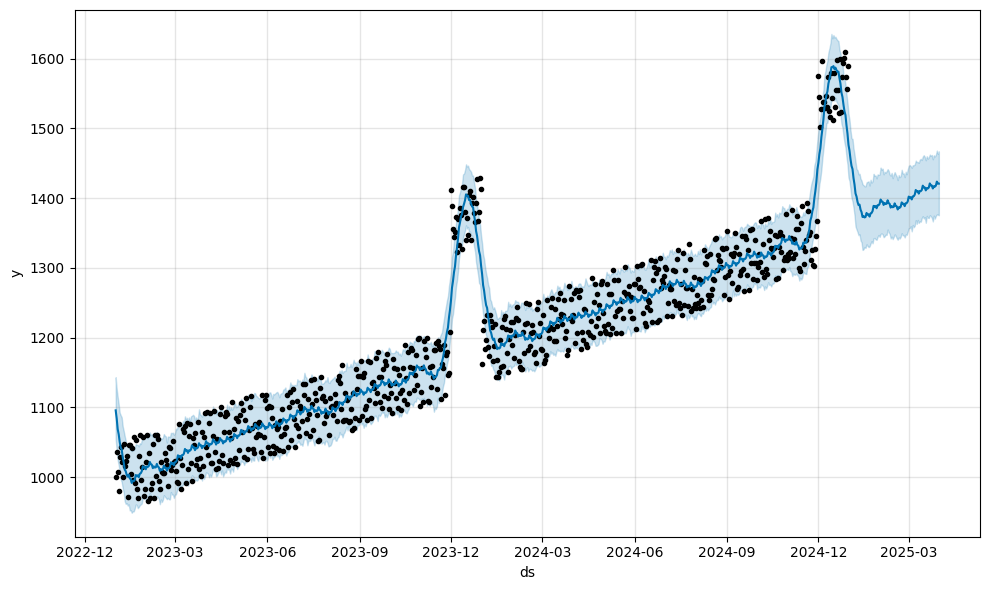

In [7]:
# --- PHASE 4b: The AI Prediction ---

# 1. Initialize the Model
# We are using the default settings, which are already very powerful.
model = Prophet()

# 2. Train the model (Fit)
# This is where the AI "learns" the patterns from your history.
model.fit(sales_df)

# 3. Create a "Future" placeholder
# We ask the model to create a table that includes the past + 90 days into the future.
future = model.make_future_dataframe(periods=90)

# 4. Make the Prediction
# The model fills in the 'y' values for those future dates.
forecast = model.predict(future)

# 5. Visualize the Result
# Black dots = Your actual historical data
# Blue line = The model's best guess (Trend)
# Light Blue shaded area = The "Confidence Interval" (Best/Worst Case)
fig1 = model.plot(forecast)

In [8]:
# --- STEP 5: Exporting Data for Power BI ---
from google.colab import files
import pandas as pd

# --- PART 1: Export PVM Data ---
# We use the 'summary_df' we created in Module 1
if 'summary_df' in locals():
    summary_df.to_csv('PVM_Analysis_Output.csv', index=False)
    print("✅ PVM Data generated successfully.")
    files.download('PVM_Analysis_Output.csv')  # This triggers the browser download
else:
    print("⚠️ Error: 'summary_df' is missing. Did you run the Aggregation Step?")

# --- PART 2: Export Forecast Data ---
# We use the 'forecast' data from Module 2, but we clean it first
if 'forecast' in locals():
    # 1. Select only the columns we need for the dashboard
    clean_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

    # 2. Rename columns to be business-friendly
    clean_forecast.columns = ['Date', 'Forecast_Value', 'Best_Case', 'Worst_Case']

    # 3. Save and Download
    clean_forecast.to_csv('Sales_Forecast_Output.csv', index=False)
    print("✅ Forecast Data generated successfully.")
    files.download('Sales_Forecast_Output.csv')  # This triggers the browser download
else:
    print("⚠️ Error: 'forecast' is missing. Did you run the Prophet Step?")

✅ PVM Data generated successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Forecast Data generated successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>